<a href="https://colab.research.google.com/github/yeesem/Deep_Learning/blob/main/Time_Series_Data_with_CNN_and_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

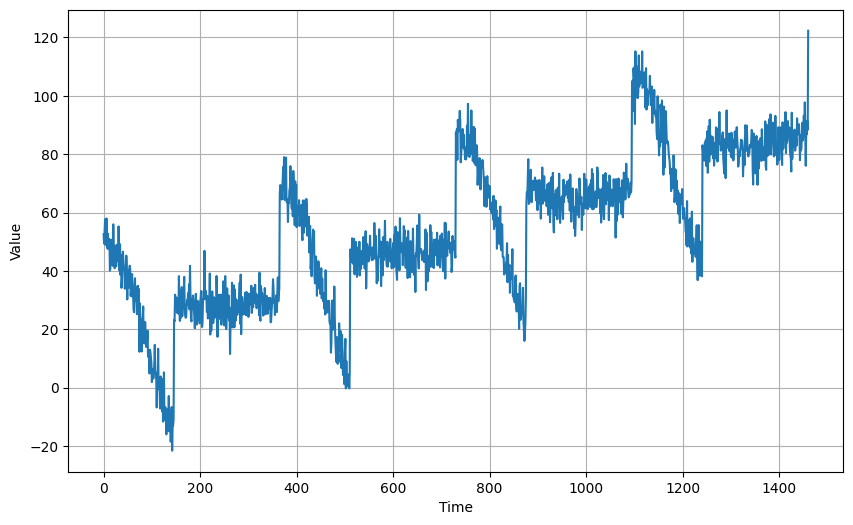

In [3]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series, xlabel='Time', ylabel='Value')

# Split the dataset

In [4]:
# Split the dataset
split_time = 1000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time : ]
x_valid = series[split_time : ]

# Prepares features and labels

In [5]:
# Parameters
window_size = 20
batch_size = 16
shuffle_buffer_size = 1000

In [7]:
def windowed_dataset(series,window_size,batch_size,shuffle_batch_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)

  dataset = dataset.window(window_size + 1,shift = 1,drop_remainder = True)

  dataset = dataset.flat_map(lambda window : window.batch(window_size + 1))

  dataset = dataset.map(lambda window : (window[:-1],window[-1]))

  dataset = dataset.shuffle(shuffle_buffer_size)

  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [8]:
# Generate the dataset window
train_set = windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)

# Build the model

In [12]:
# Reset states generated by keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(
      filters = 64,
      kernel_size = 3,
      strides = 1,
      padding = 'causal',
      activation = 'relu',
      input_shape = [window_size,1]
  ),
  tf.keras.layers.LSTM(64,return_sequences = True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x : x * 400)
])

# Print the summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 20, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 66369 (259.25 KB)
Trainable params: 66369 (259.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Tune the learning rate

In [13]:
# Get the initial weights
inits_weights = model.get_weights()

In [14]:
# Set the learning rate scheduler
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch : 1e-8 * 10 ** (epoch / 20)
)

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum = 0.9)

# Set the training parameters
model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = optimizer
)

# Train the model
history = model.fit(
    train_set,
    epochs = 100,
    callbacks = [lr_scheduler]
)

Epoch 1/100
62/62 [==============================] - 8s 23ms/step - loss: 21.3001 - lr: 1.0000e-08
Epoch 2/100
62/62 [==============================] - 2s 23ms/step - loss: 16.1590 - lr: 1.1220e-08
Epoch 3/100
62/62 [==============================] - 2s 23ms/step - loss: 14.2324 - lr: 1.2589e-08
Epoch 4/100
62/62 [==============================] - 2s 22ms/step - loss: 12.6210 - lr: 1.4125e-08
Epoch 5/100
62/62 [==============================] - 2s 36ms/step - loss: 11.6958 - lr: 1.5849e-08
Epoch 6/100
62/62 [==============================] - 2s 26ms/step - loss: 11.0532 - lr: 1.7783e-08
Epoch 7/100
62/62 [==============================] - 2s 23ms/step - loss: 10.6020 - lr: 1.9953e-08
Epoch 8/100
62/62 [==============================] - 2s 22ms/step - loss: 10.3977 - lr: 2.2387e-08
Epoch 9/100
62/62 [==============================] - 2s 23ms/step - loss: 10.1258 - lr: 2.5119e-08
Epoch 10/100
62/62 [==============================] - 3s 40ms/step - loss: 9.8670 - lr: 2.8184e-08
Epoch 11/1

(1e-08, 0.001, 0.0, 50.0)

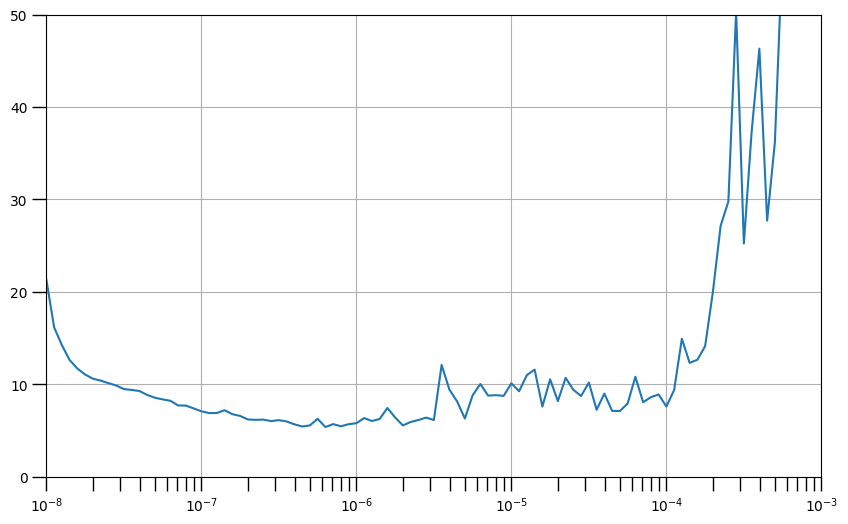

In [17]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100)/20))

# Set the figure size
plt.figure(figsize = (10,6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs,history.history['loss'])

# Increase the tickmarks size
plt.tick_params('both',length = 10,width = 1,which = 'both')

# Set the plot boundaries
plt.axis([1e-8,1e-3,0,50])

# Train the model

In [19]:
# Set the learning rate
learning_rate = 1e-7

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(
    learning_rate = learning_rate,
    momentum = 0.9
)

# Set the training parameters
model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = optimizer,
    metrics = ['mae']
)

In [20]:
# Train the model
history = model.fit(
    train_set,
    epochs = 500
)

Epoch 1/500
62/62 [==============================] - 13s 45ms/step - loss: 91.9279 - mae: 92.4279
Epoch 2/500
62/62 [==============================] - 3s 46ms/step - loss: 81.8637 - mae: 82.3637
Epoch 3/500
62/62 [==============================] - 3s 36ms/step - loss: 71.5634 - mae: 72.0634
Epoch 4/500
62/62 [==============================] - 2s 23ms/step - loss: 61.2693 - mae: 61.7693
Epoch 5/500
62/62 [==============================] - 2s 35ms/step - loss: 50.9999 - mae: 51.4999
Epoch 6/500
62/62 [==============================] - 2s 24ms/step - loss: 40.8923 - mae: 41.3919
Epoch 7/500
62/62 [==============================] - 2s 23ms/step - loss: 31.2409 - mae: 31.7401
Epoch 8/500
62/62 [==============================] - 2s 24ms/step - loss: 22.9127 - mae: 23.4094
Epoch 9/500
62/62 [==============================] - 2s 23ms/step - loss: 17.8429 - mae: 18.3338
Epoch 10/500
62/62 [==============================] - 2s 29ms/step - loss: 16.0365 - mae: 16.5291
Epoch 11/500
62/62 [========

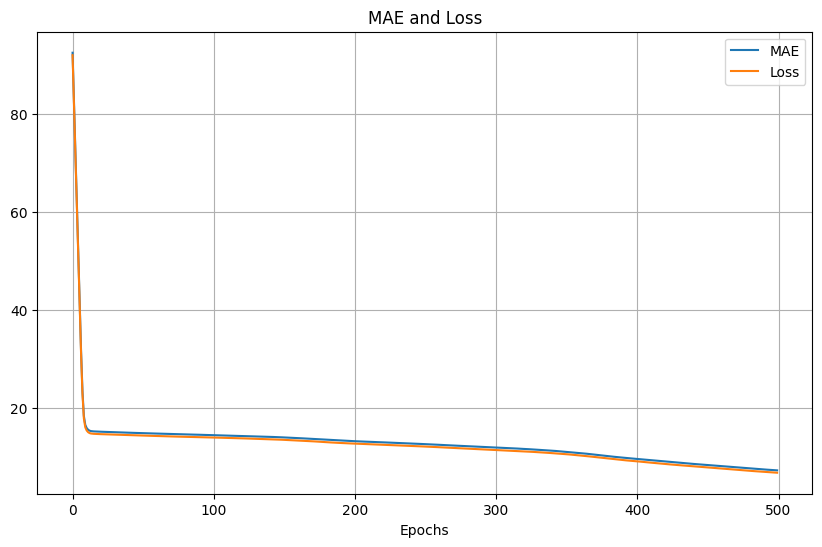

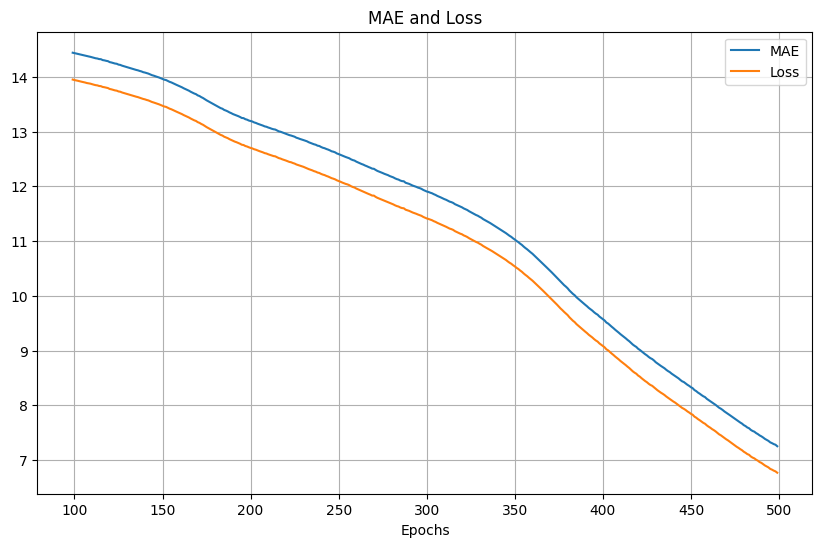

In [22]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss))

# Plot mae and loss
plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss',
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )

# Model Prediction

In [31]:
def model_forecast(model,series,window_size,batch_size):
   dataset = tf.data.Dataset.from_tensor_slices(series)

   dataset = dataset.window(window_size,shift = 1,drop_remainder = True)

   dataset = dataset.flat_map(lambda w : w.batch(window_size))

   dataset = dataset.batch(batch_size).prefetch(1)

   forecast = model.predict(dataset)

   return forecast

29/29 [==============================] - 0s 12ms/step


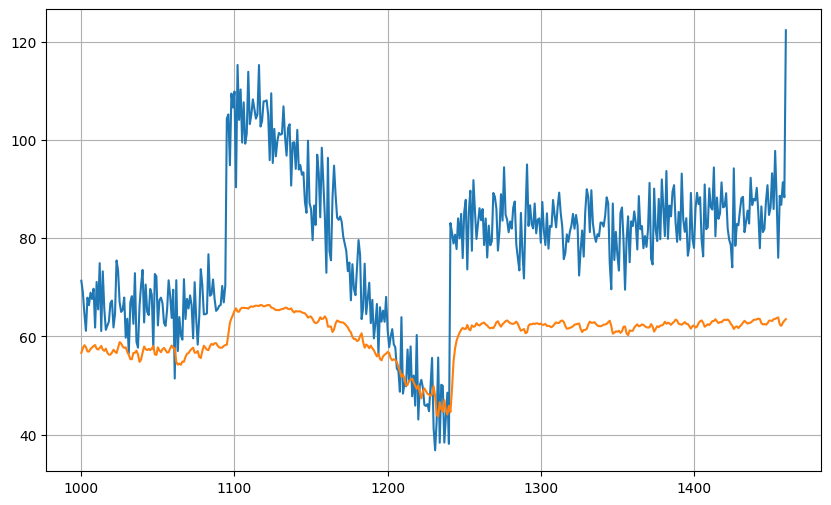

In [32]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axes
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [28]:
## Compute the MAE and MSE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

459.00156
18.624084


# Adding Callback for Early Stopping

In [34]:
# Generate data windows from the validation set
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [36]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs = {}):
    if (logs.get('val_mae') < 5.2):

      # Stop if thredhold is met
      print("\nRequired val MAE is met so cancelling training")
      self.model.stop_training = True

# Instantiate the class
callbacks = myCallback()

In [37]:
# Set the learning rate
learning_rate = 4e-8

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(
    learning_rate = learning_rate,
    momentum = 0.9
)

# Set the training parameters
model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = optimizer,
    metrics = ['mae']
)

# Train the model
history = model.fit(train_set, epochs=500, validation_data=val_set, callbacks=[callbacks])

Epoch 1/500
62/62 [==============================] - 10s 92ms/step - loss: 6.7496 - mae: 7.2329 - val_loss: 18.5544 - val_mae: 19.0509
Epoch 2/500
62/62 [==============================] - 2s 28ms/step - loss: 6.7407 - mae: 7.2242 - val_loss: 18.5357 - val_mae: 19.0321
Epoch 3/500
62/62 [==============================] - 2s 27ms/step - loss: 6.7336 - mae: 7.2176 - val_loss: 18.3962 - val_mae: 18.8933
Epoch 4/500
62/62 [==============================] - 2s 28ms/step - loss: 6.7264 - mae: 7.2113 - val_loss: 18.4195 - val_mae: 18.9165
Epoch 5/500
62/62 [==============================] - 3s 45ms/step - loss: 6.7211 - mae: 7.2039 - val_loss: 18.4413 - val_mae: 18.9381
Epoch 6/500
62/62 [==============================] - 2s 28ms/step - loss: 6.7110 - mae: 7.1947 - val_loss: 18.4238 - val_mae: 18.9205
Epoch 7/500
62/62 [==============================] - 2s 34ms/step - loss: 6.7045 - mae: 7.1882 - val_loss: 18.3869 - val_mae: 18.8838
Epoch 8/500
62/62 [==============================] - 3s 39ms/

29/29 [==============================] - 1s 9ms/step


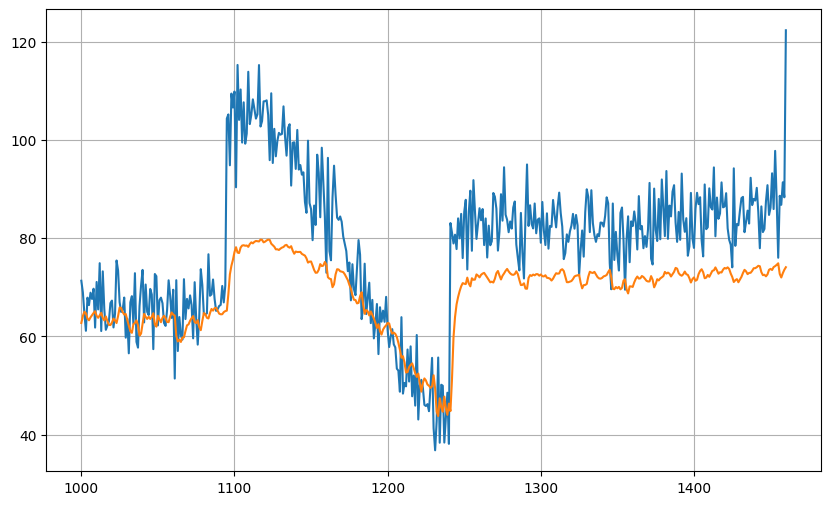

In [38]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [39]:
## Compute the MAE and MSE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

180.21265
10.77565
